In [1]:
#create mesh and function space#

In [2]:
from dolfinx import fem, mesh, plot
import numpy as np
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction, 
                 div, dx, ds, grad, inner)

N = 8
domain = mesh.create_unit_square(MPI.COMM_WORLD, N, N)
V = fem.FunctionSpace(domain, ("CG", 1))


In [3]:
#function containing exact sol. and corresponding source function for right hand side

In [4]:
uD = fem.Function(V)
x = SpatialCoordinate(domain)
u_ex = 1 + x[0] ** 2 + 2 * x[1] ** 2 
uD.interpolate(fem.Expression(u_ex, V.element.interpolation_points))
f = - div(grad(u_ex))

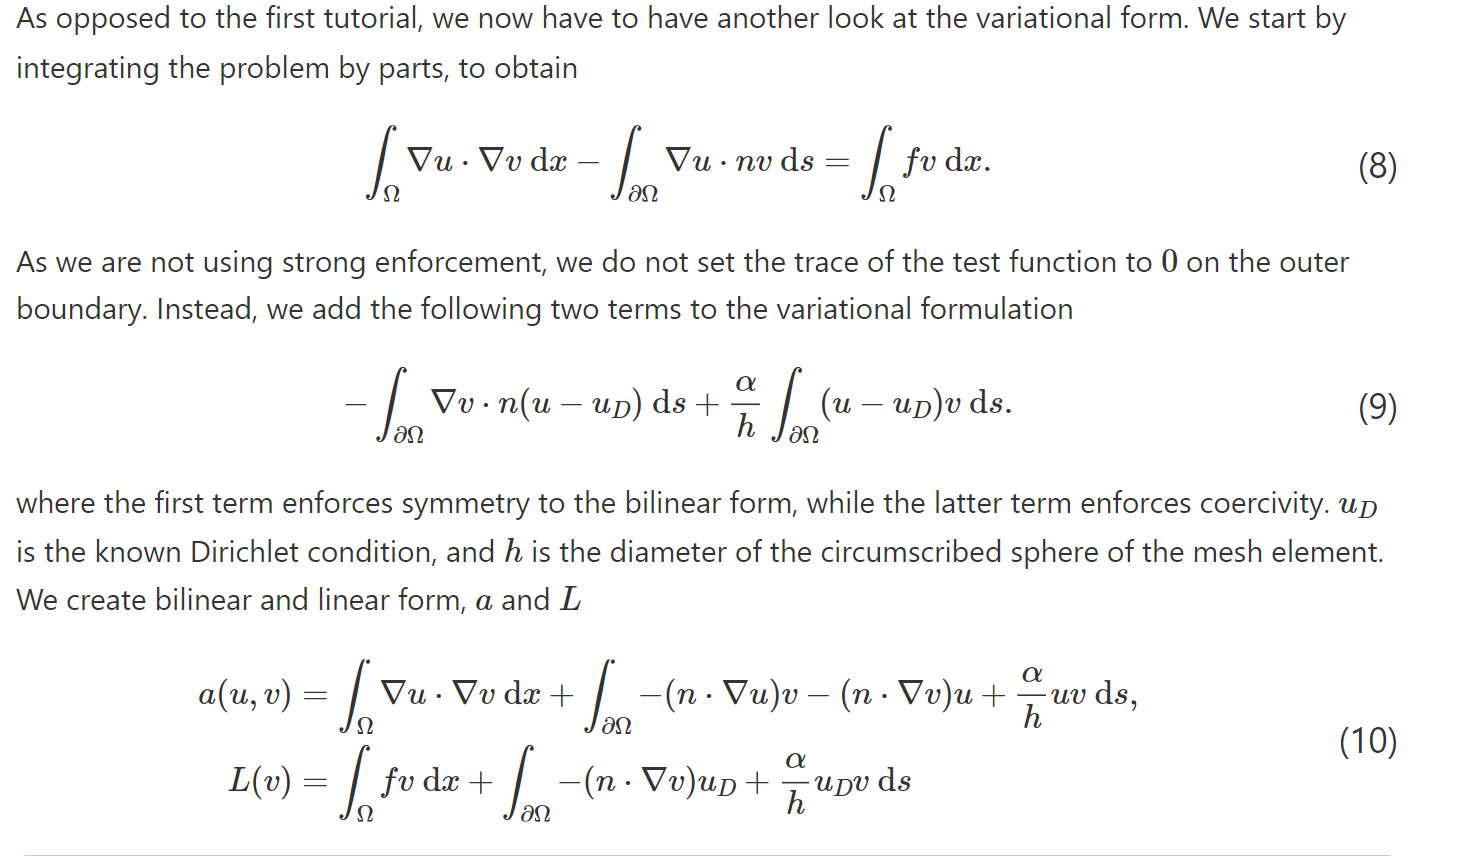


In [5]:
u = TrialFunction(V)
v = TestFunction(V)
n = FacetNormal(domain)
h = 2 * Circumradius(domain)
alpha = fem.Constant(domain, ScalarType(10))
a = inner(grad(u), grad(v)) * dx - inner(n, grad(u)) * v * ds
a += - inner(n, grad(v)) * u * ds + alpha / h * inner(u, v) * ds
L = inner(f, v) * dx
L += - inner(n, grad(v)) * uD * ds + alpha / h * inner(uD, v) * ds


In [6]:
problem = fem.LinearProblem(a, L)
petsc_options = {"ksp_type": "preonly", "pc_type": "lu"}
uh = problem.solve()

In [7]:
#Computing error by comparison to analytic sol

In [8]:
error_form = fem.form(inner(uh - uD, uh - uD) * dx)
error_local = fem.assemble_scalar(error_form)
errorL2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

if domain.comm.rank == 0:
    print(fr"$L^2$-error: {errorL2:.2e}")


$L^2$-error: 1.59e-03


In [9]:
#Compute maximal error for all degrees of freedom

In [10]:
error_max = domain.comm.allreduce(np.max(np.abs(uD.x.array - uh.x.array)), op=MPI.MAX)

if domain.comm.rank == 0:
    print(f"Error_max: {error_max:.2e}")

Error_max: 5.41e-03


In [11]:
import pyvista
pyvista.set_jupyter_backend("pythreejs")

grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(V))
grid.point_data["u"] = uh.x.array.real
grid.set_active_scalars("u")

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True)
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    pyvista.start_xvfb()
    figure = plotter.screenshot("DirichletBC.png")

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(color='#fefefe', inten…